Définition du modèle UNET binary, c'est à dire une classe (piéton) et le fond.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.optimizers import Adam

# Chemins des données
train_images_path = "/Users/quentinlandon/Desktop/GIT_Projet_theo/APP_IA_TL_QL_dev/datapieton/Binary_seg/train_images"
train_masks_path = "/Users/quentinlandon/Desktop/GIT_Projet_theo/APP_IA_TL_QL_dev/datapieton/Binary_seg/train_masks"
valid_images_path = "/Users/quentinlandon/Desktop/GIT_Projet_theo/APP_IA_TL_QL_dev/datapieton/Binary_seg/valid_images"
valid_masks_path = "/Users/quentinlandon/Desktop/GIT_Projet_theo/APP_IA_TL_QL_dev/datapieton/Binary_seg/valid_masks"

# Fonction pour charger les images et les masques
def load_images_and_masks(image_path, mask_path):
    images = []
    masks = []
    for img_file in os.listdir(image_path):
        if img_file.endswith(".png"):
            img = load_img(os.path.join(image_path, img_file), target_size=(256, 256))
            mask_file = img_file.replace(".png", "_mask.png")  # Assuming mask filenames are derived from image filenames
            mask = load_img(os.path.join(mask_path, mask_file), target_size=(256, 256), color_mode='grayscale')
            images.append(img_to_array(img))
            masks.append(img_to_array(mask))
    return np.array(images), np.array(masks)

# Chargement des images et des masques d'entraînement
x_train, y_train = load_images_and_masks(train_images_path, train_masks_path)

# Chargement des images et des masques de validation
x_valid, y_valid = load_images_and_masks(valid_images_path, valid_masks_path)

# Construction du modèle U-Net
def unet(input_shape):
    inputs = Input(input_shape)
    
    # Chemin contractant
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Fond
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Chemin expansif
    up4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = concatenate([up4, conv2], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv1], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Couche de sortie
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Création du modèle U-Net
input_shape = (256, 256, 3)  # Taille d'entrée
model = unet(input_shape)

# Compilation du modèle
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


Entrainement du modèle

In [2]:

# Entraînement du modèle
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_valid, y_valid))

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 110s 21s/step - accuracy: 0.5098 - loss: 5.3234 - val_accuracy: 0.1170 - val_loss: 1.5135
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 120s 22s/step - accuracy: 0.5262 - loss: 1.4176 - val_accuracy: 0.8298 - val_loss: 0.8397
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 118s 23s/step - accuracy: 0.5897 - loss: 0.8350 - val_accuracy: 0.7958 - val_loss: 0.5866
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 102s 20s/step - accuracy: 0.8013 - loss: 0.6592 - val_accuracy: 0.6874 - val_loss: 0.5956
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 103s 20s/step - accuracy: 0.7247 - loss: 0.5915 - val_accuracy: 0.7375 - val_loss: 0.5271
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 99s 19s/step - accuracy: 0.7466 - loss: 0.5506 - val_accuracy: 0.8068 - val_loss: 0.4616
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 98s 19s/step - accuracy: 0.7829 - loss: 0.5038 - val_accuracy: 0.7206 - val_loss: 0.4270
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 101s 20s/step - accuracy: 0.7330 - loss: 0.5137 - val_accuracy: 0.8074 - val_loss: 0

Enregistrement du modèle

In [3]:
import os
from tkinter import Tk, filedialog

# Créer une fenêtre Tkinter
root = Tk()
root.withdraw()  # Pour cacher la fenêtre principale

# Demander à l'utilisateur de choisir le chemin d'enregistrement
save_path = filedialog.asksaveasfilename(defaultextension=".h5", filetypes=[("Model files", "*.h5")])

# Demander à l'utilisateur le nom du modèle
model_name = input("Veuillez saisir le nom du modèle : ")

# Vérifier si le nom du modèle a été saisi
if not model_name:
    print("Le nom du modèle est vide. Veuillez saisir un nom valide.")
    exit()

# Vérifier si le chemin d'enregistrement a été choisi
if not save_path:
    print("Aucun chemin d'enregistrement sélectionné. L'enregistrement du modèle est annulé.")
    exit()

# Enregistrer le modèle
model.save(os.path.join(save_path, model_name + ".h5"))


Visualisation du modèle (score, image path..)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


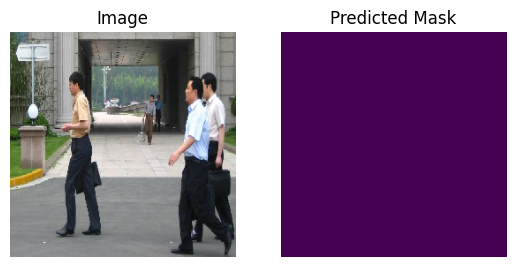

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model


def visualize_result(model_path, image_path=None, image=None, true_mask=None):
    # Charger le modèle
    model = load_model(model_path)

    # Visualisation des résultats sur une image brute non labellisée
    # Charger l'image
    image = load_img(image_path, target_size=(256, 256))
    image_array = img_to_array(image)
    
    # Prédiction du masque avec le modèle
    predicted_mask = model.predict(np.expand_dims(image_array, axis=0))[0]
    
    # Convertir le masque prédit en classes (0, 1, 2, ...)
    predicted_class = np.argmax(predicted_mask, axis=-1)
    
    # Afficher l'image et le masque prédit
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_class, cmap='viridis', vmin=0, vmax=np.max(predicted_class))
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

# Chemin du modèle
model_path = input("Entrez le chemin du modèle : ")

image_path = input("Entrez le chemin de l'image à visualiser : ")
visualize_result(model_path, image_path=image_path)

